# Birchli PV Produktions Leistungs Analyse

## Import

More information about impyla see here: https://github.com/cloudera/impyla.

In [1]:
from impala.dbapi import connect 
from impala.util import as_pandas
import pandas as pd # For Data Handling
import numpy as np  # data processing, CSV file I/O (e.g. pd.read_csv)
import math as mt
import datetime as dt # To convert timestamp data
import matplotlib   #for plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
matplotlib.style.use('ggplot')
%matplotlib inline

## Connect to DataHost wh-02 (172.16.10.102)

Connect to Impala and execute show tables to see all avilable tables.

In [2]:
# jdbc:impala://zhhaphmp-hala01.it.bwns.ch:21050;AuthMech=0;
conn = connect(host='172.16.10.102', port=21050)
cur = conn.cursor()
cur.execute('SHOW TABLES')
dfp = as_pandas(cur)
cur.close()
#To see all tables tip only dfp without .head()
dfp.head()

,name
0,birchli_roh
1,inventory_solar
2,meteo_einsiedeln
3,open_weather_6340_1513956438
4,solarlog


Connect to DataNode and show 5 entries from the solarlog_roh table.

In [3]:
#Test other aproach to select
# jdbc:impala://zhhaphmp-hala01.it.bwns.ch:21050;AuthMech=0;
conn = connect(host='172.16.10.102', port=21050)
cur = conn.cursor()
cur.execute('SELECT * FROM birchli_roh order by `timestamp`')
df = as_pandas(cur)
cur.close()
conn.close()
#To see all tables tip only dfp without .head()
df.head()

,id,timestamp,yield_1,yield_2,yield_tot
0,0,2010-11-30 00:00:00,0.0,NaN,0.0
1,1,2010-11-30 00:10:00,0.0,NaN,0.0
2,2,2010-11-30 00:20:00,0.0,NaN,0.0
3,3,2010-11-30 00:30:00,0.0,NaN,0.0
4,4,2010-11-30 00:40:00,0.0,NaN,0.0


In [4]:
len(df)

342720

In [5]:
df.describe().yield_tot

count    342720.000000
mean          0.700203
std          82.911864
min           0.000000
25%           0.000000
50%           0.000000
75%           0.492000
max       38981.946000
Name: yield_tot, dtype: float64

Are there outliners? More than 8 kWh yield energy is not possible!

In [6]:
df[df.yield_tot>8]

,id,timestamp,yield_1,yield_2,yield_tot
160193,160193,2013-12-16 10:50:00,0.0,28916.460,28916.460
224014,224014,2015-03-04 15:40:00,0.0,38981.946,38981.946
296404,296404,2016-12-09 08:40:00,0.0,8.754,8.754


In [7]:
dfc = df.drop(df[df.yield_tot>8].index)

In [8]:
dfc.describe().yield_tot

count    342717.000000
mean          0.502066
std           0.947222
min           0.000000
25%           0.000000
50%           0.000000
75%           0.492000
max           4.890000
Name: yield_tot, dtype: float64

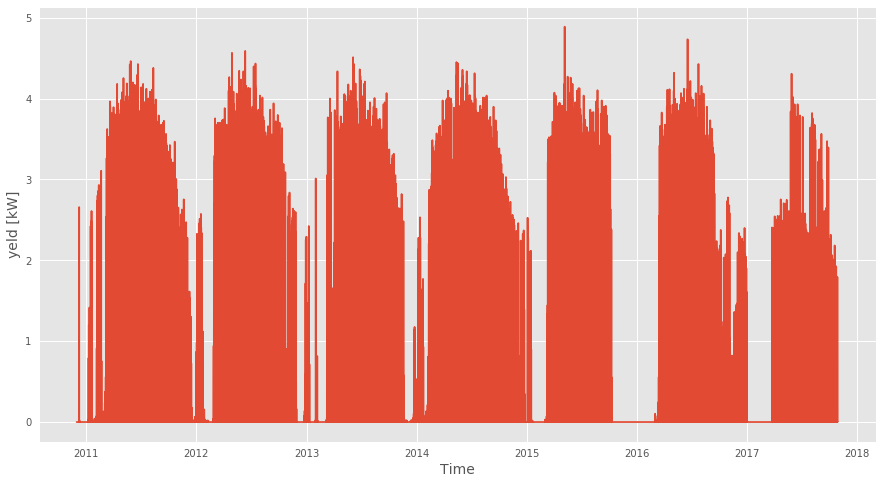

In [9]:
# Time Series Plot
plt.figure(figsize = (15,8))
plt.plot(dfc.timestamp,dfc.yield_tot)
plt.ylabel("yeld [kW]",size=14)
plt.xlabel("Time",size=14)
plt.show()

## Table Aggregation
Dayliy, Monthly and Yearly Aggregation <br>
Some ideas see here https://www.shanelynn.ie/summarising-aggregatio

In [10]:
#Dayli Agregation
dfc['day'] = dfc['timestamp'].dt.strftime('%Y-%m-%d')
dfc['month'] = dfc['timestamp'].dt.strftime('%Y-%m')
dfc['year'] = dfc['timestamp'].dt.strftime('%Y')
dfc.head()

,id,timestamp,yield_1,yield_2,yield_tot,day,month,year
0,0,2010-11-30 00:00:00,0.0,NaN,0.0,2010-11-30,2010-11,2010
1,1,2010-11-30 00:10:00,0.0,NaN,0.0,2010-11-30,2010-11,2010
2,2,2010-11-30 00:20:00,0.0,NaN,0.0,2010-11-30,2010-11,2010
3,3,2010-11-30 00:30:00,0.0,NaN,0.0,2010-11-30,2010-11,2010
4,4,2010-11-30 00:40:00,0.0,NaN,0.0,2010-11-30,2010-11,2010


### Dayli Aggregation (sum,max,min,mean,median)

In [96]:
# Build Dayli Aggregation with sum, max, min, mean
df_day = pd.DataFrame(dfc.groupby('day')['yield_tot'].sum()/6)
df_day['yield_max'] = dfc.groupby('day')['yield_tot'].max()
df_day['yield_median'] = dfc.groupby('day')['yield_tot'].median()
df_day['yield_mean'] = dfc.groupby('day')['yield_tot'].mean()
df_day['month'] = dfc['timestamp'].dt.month
#df_month['year'] = dfc['timestamp'].dt.year
df_day.head()

,yield_tot,yield_max,yield_median,yield_mean,month
day,,,,,
2010-11-30,0.0,0.0,0.0,0.0,NaN
2010-12-01,0.0,0.0,0.0,0.0,NaN
2010-12-02,0.0,0.0,0.0,0.0,NaN
2010-12-03,0.0,0.0,0.0,0.0,NaN
2010-12-04,0.0,0.0,0.0,0.0,NaN


In [97]:
# Careful this plot takes a while to render


#mport plotly
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#from plotly.graph_objs import *
#init_notebook_mode(connected=True) #need to use plotly offline

#data = Data([Bar(x=df_day.index, y=df_day.yield_tot, name='SUM [kWh]'),
#             Bar(x=df_day.index, y=df_day.yield_max, name='MAX [kW]'),
#             Bar(x=df_day.index, y=df_day.yield_median, name='MEDIAN [kW]'),
#             Bar(x=df_day.index, y=df_day.yield_mean, name='MEAN [kW]')])
             

#iplot(Figure(data=data, layout= Layout(title='Daily Aggregation Birchli Yield [kW]')))


### Monthly Aggregation (sum,max,min,mean,median)

In [98]:
# Build Dayli Aggregation with sum, max, min, mean
df_month = pd.DataFrame(dfc.groupby('month')['yield_tot'].sum()/6) # 10 Min Wert Basis
df_month['yield_max'] = dfc.groupby('month')['yield_tot'].max()
df_month['yield_median'] = df_day.groupby('month')['yield_median'].median()
df_month['yield_mean'] = df_day.groupby('month')['yield_mean'].mean()
df_month['year'] = dfc['timestamp'].dt.year
df_month.head()

,yield_tot,yield_max,yield_median,yield_mean,year
month,,,,,
2010-11,0.000,0.000,NaN,NaN,NaN
2010-12,4.674,2.658,NaN,NaN,NaN
2011-01,51.526,2.610,NaN,NaN,NaN
2011-02,193.006,3.108,NaN,NaN,NaN
2011-03,389.145,3.966,NaN,NaN,NaN


In [99]:
# Careful this plot takes a while to render
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) #need to use plotly offline

data = Data([Bar(x=df_month.index, y=df_month.yield_tot, name='SUM [kW]'),
             Bar(x=df_month.index, y=df_month.yield_max, name='MAX [kW]')])
             

iplot(Figure(data=data, layout= Layout(title='Montly Aggregation Birchli Yield [kW]')))

### Yearly Aggregation (sum,max,min,mean,median)

In [100]:
# Build Dayli Aggregation with sum, max, min, mean
df_year = pd.DataFrame(dfc.groupby('year')['yield_tot'].sum()/6) # Korrekture 10 min Wertebasis
df_year['yield_max'] = dfc.groupby('year')['yield_tot'].max()
df_year['yield_median'] = dfc.groupby('year')['yield_tot'].median()
df_year['yield_mean'] = dfc.groupby('year')['yield_tot'].mean()

In [101]:
# Drope 2010 und 2017 da diese nicht volständig sind
df_year = df_year[(df_year.index != '2010') & (df_year.index != '2017')]
yield_median = round(df_year.yield_tot.median())
spez_yield = round(yield_median / (0.179*27.9))
print('Ertrags Median = ' + str(yield_median) +' [kWh]')
print('Spezifischer Ertrag = ' + str(spez_yield) + ' [kWh/kwp]')

Ertrags Median = 4256 [kWh]
Spezifischer Ertrag = 852 [kWh/kwp]


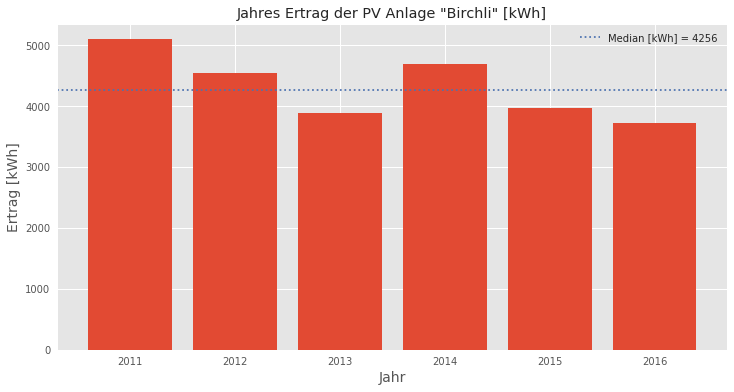

In [102]:

# Time Series Plot
plt.figure(figsize = (12,6))
plt.bar(df_year.index, df_year.yield_tot,)
plt.ylabel("Ertrag [kWh]",size=14)
plt.xlabel("Jahr",size=14)
plt.title('Jahres Ertrag der PV Anlage "Birchli" [kWh]')
plt.axhline(yield_median,ls='dotted',label="Median [kWh] = " + str(yield_median), color='b')
plt.legend()
plt.savefig("birchli_jahresertrag.pdf")
plt.show()


# Analytical Questions & Hypoteses
## Hypoteses
1. Die Spiezenwerte (max) der produzierten Leistung nehmen über die Jahre ab. 

### Abnahme der Spizenwerte (max) über die Zeit
Die Idee bei der Verwendeung der Maximalwerten einer gewissen Jahreszeit ist, dass wir hier nur schöne Tage vergleichen. So sollte die Vergelichbarkeit gegeben sein.

Vergleichen der Tages Maximas aller Jahre (Distanz)


In [19]:

#print(df_day[('11-30' in df_day.index)].yield_max)